<h2 style="text-align: center;">Generalized method of moments</h2>


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from scipy.special import comb  # For binomial coefficients


In [31]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                + self.sigma * np.sqrt((1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


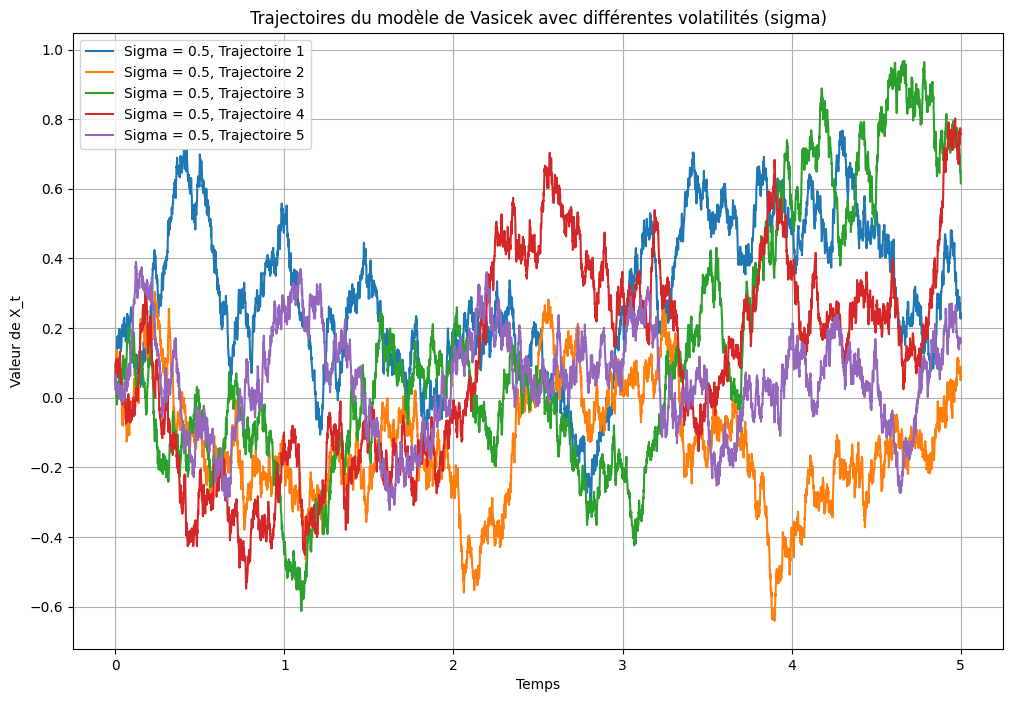

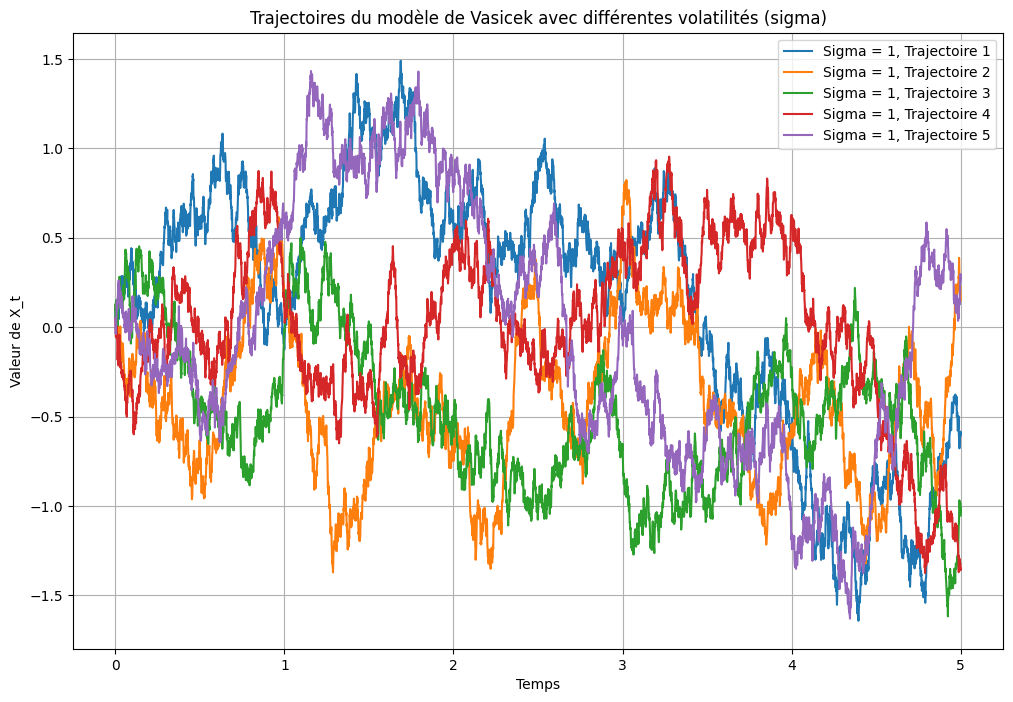

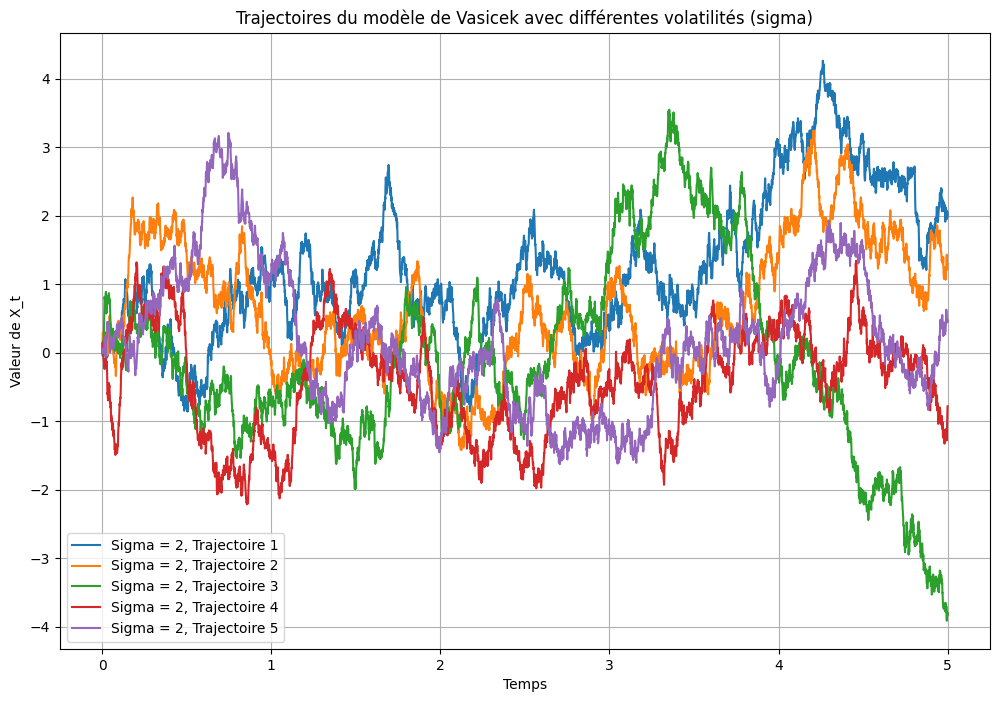

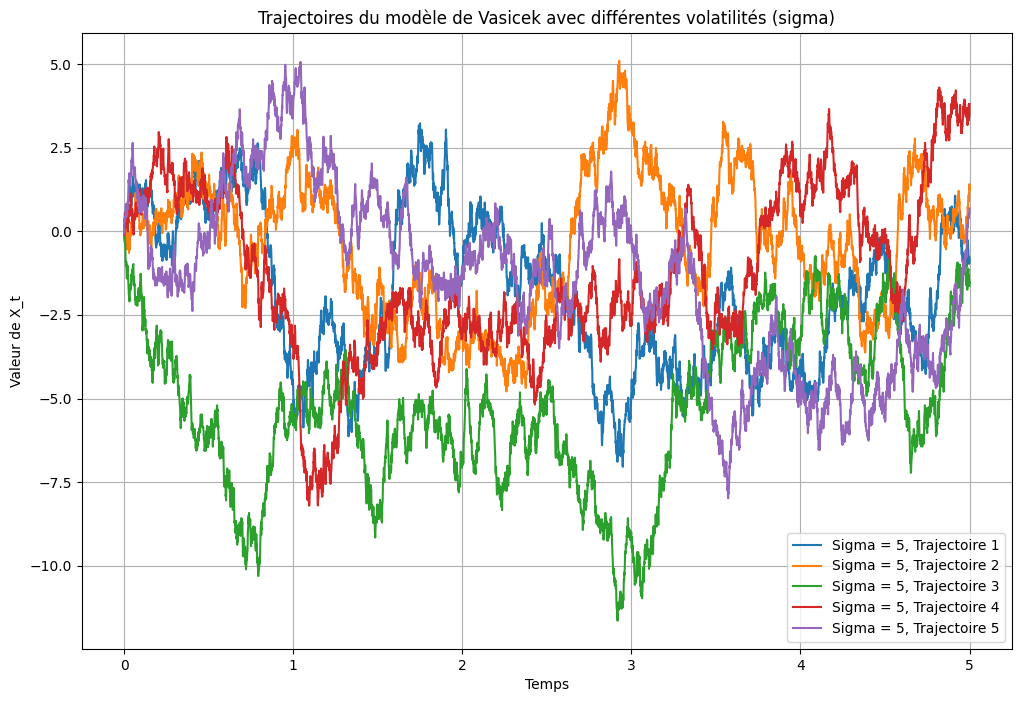

In [32]:


# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 5  # durée totale

# Liste des valeurs de sigma
sigma_values = [0.5, 1, 2, 5]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(12, 8))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


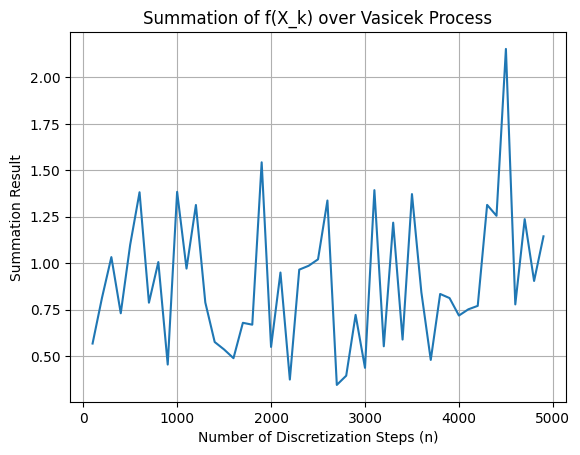

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    trajectory = trajectories[0]  # Take the first trajectory

    # Compute the summation
    return (1 / n) * sum(f(x) for x in trajectory)

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(100, 5000, 100)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n

# Plot the results
plt.plot(n_values, Y)
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.show()


In [34]:
import math
from scipy.special import comb

def expected_value_vasicek(n, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(n + 1):
        # Binomial coefficient
        binom_coeff = comb(n, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(n - k)
        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
theta = 1
sigma = 0.5
kappa = 1
n = 1

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 1.0


Theoretical Expected Value: 2.484375


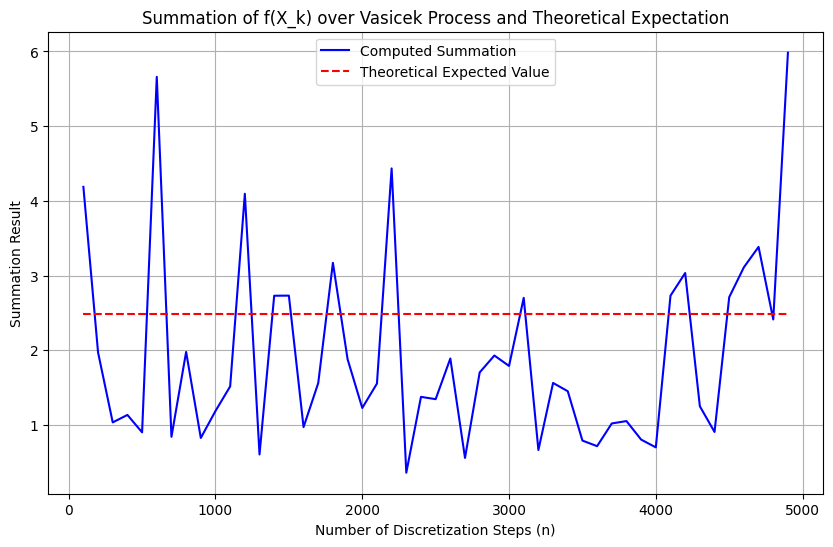

In [35]:
import matplotlib.pyplot as plt

# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0.5  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
T = 10
n_values = range(100, 5000, 100)  # Range of n values for testing

# Define the function to apply to each X_k
f = lambda x: x**5# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa, theta=theta, sigma=sigma, X0=X0,T=T) for n in n_values]

# Compute the true value of the expectation
n = 5 # Choose a large n for comparison
true_value = expected_value_vasicek(n, theta, sigma, kappa)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value

# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


In [59]:
def parameter_estimator(n):
    """Generalized Method of Moments estimator for the Vasicek model."""
    def matrix_calculator(params):
        theta, sigma, kappa = params
        # Initialize Z and Y arrays
        Z = np.zeros(n)
        Y = np.zeros(n)
        
        # Compute Z values
        for i in range(n):
            Z[i] = expected_value_vasicek(i + 1, theta, sigma, kappa)
        
        # Compute Y values
        for i in range(n):
            Y[i] = calculate_sum(i + 1, lambda x: x ** (i + 1), kappa=kappa, theta=theta, sigma=sigma, X0=0.05, T=5)
        
        # Return the squared norm of the difference
        diff = Y - Z
        return np.dot(diff, diff)
    
    # Initial guess for [theta, sigma, kappa]
    initial_guess = [1, 0.5, 5]
    
    # Perform minimization
    res = minimize(matrix_calculator, initial_guess, method='Nelder-Mead', 
                options={'xatol': 1e-3, 'disp': True, 'maxfev': 10000})    
    # Return optimized parameters
    return res.x

# Example usage
print(parameter_estimator(5))


Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 136
         Function evaluations: 347
[0.04776229 0.61710221 6.42497922]
